# Machine Learning-based Categorization of Cybersecurity Vulnerabilities.

#  Overview
Common Vulnerabilities and Exposures (CVE) is a list of computer security threats provided by the U.S. Department of Homeland Security and maintained by the MITRE corporation.

Per MITRE's terminology documentation, CVE distinguishes between vulnerabilities where



> Indented block A "vulnerability" is a weakness in the computational logic (e.g., code) found in software and some hardware components (e.g., firmware) that, when exploited, results in a negative impact to confidentiality, integrity, OR availability. Mitigation of the vulnerabilities in this context typically involves coding changes, but could also include specification changes or even specification deprecations (e.g., removal of affected protocols or functionality in their entirety).


* CVE considers a configuration issue or a mistake an exposure if it does not directly allow compromise but could be an important component of a successful attack, and is a violation of a reasonable security policy.








# SET GPU

In [3]:
import torch

print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

PyTorch version: 2.0.0
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


In [4]:
# importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

import warnings

#from pandas.core.common import SettingWithCopyWarning



In [5]:
#!pip install seaborn

In [6]:
import seaborn as sns

## connect colab with google drive

In [7]:
from google.colab import drive
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google.colab'

In [8]:

!pwd

/Users/anthonyekle/Downloads


In [9]:
# datas

# DataSet Details and Loading
## CVE Dataset with Vulnerability Types (1999-2019)

This dataset is scraped from CVEDetails.com website, using a custom script. The script collected the unique CVEs for period of 20 years (1999-2019) and after that merged them in a single dataset. Each CVE record has specified zero or more vulnerability types, up to maximum four. The vulnerability types are presented in the dataset as follows:
  * {'NaN', 'DoS', 'Exec Code', 'Overflow', 'XSS', 'Dir. Trav.', 'Bypass', +Info', '+Priv', 'Sql', 'File Inclusion', 'Mem. Corr.', 'CSRF', 'Http R.Spl.'}
* Columns: 15
* Records: 123K


Venota et. al (2021) [Github link](https://gitlab.com/venetay/cve-dataset-with-vulnerability-types-1999-2019/-/blob/main/README.md)



In [10]:
# import data
#df_location = "/content/drive/MyDrive/02 PHD WORLD 2023/CSC 6230 ML Project/cve_dataset_with_vulnerability2.csv"
df = pd.read_csv("cve_dataset_with_vulnerability2.csv" )

In [11]:
df.head(3)

,CVE_ID,CWE_ID,NumExploits,VulnerabilityType,PublishDate,UpdateDate,Score,GainedAccessLevel,Access,Complexity,Authentication,Conf.,Integ.,Avail.,Descr.
0,CVE-2012-0278,119.0,NaN,Exec Code Overflow,2012-04-18,2013-02-14,9.3,None,Remote,Medium,Not required,Complete,Complete,Complete,Heap-based buffer overflow in the FlashPix Plu...
1,CVE-2012-0277,119.0,1.0,DoS Exec Code Overflow,2012-07-17,2012-08-01,6.8,None,Remote,Medium,Not required,Partial,Partial,Partial,Heap-based buffer overflow in XnView before 1....
2,CVE-2012-0276,119.0,2.0,DoS Exec Code Overflow,2012-07-17,2012-07-18,6.8,None,Remote,Medium,Not required,Partial,Partial,Partial,Multiple heap-based buffer overflows in XnView...


In [12]:
# rename score to cvss

df.rename(columns={'Score': 'cvss'}, inplace=True)


In [13]:
df.columns

Index(['CVE_ID', 'CWE_ID', 'NumExploits', 'VulnerabilityType', 'PublishDate',
       'UpdateDate', 'cvss', 'GainedAccessLevel', 'Access', 'Complexity',
       'Authentication', 'Conf.', 'Integ.', 'Avail.', 'Descr.'],
      dtype='object')

In [14]:

df['Descr.'][22]

'ImageMagick 6.7.5-7 and earlier allows remote attackers to cause a denial of service (memory corruption) and possibly execute arbitrary code via crafted offset and count values in the ResolutionUnit tag in the EXIF IFD0 of an image.'

In [15]:
df.isna().sum()

CVE_ID                    0
CWE_ID                35954
NumExploits          119210
VulnerabilityType     28430
PublishDate               0
UpdateDate                0
cvss                      0
GainedAccessLevel         0
Access                    0
Complexity                0
Authentication            0
Conf.                     0
Integ.                    0
Avail.                    0
Descr.                    1
dtype: int64

In [16]:
# number of unique vul-types
for i in df['VulnerabilityType'][1:15]:
  #if i[0:3] == "DoS":
  if "DoS" in i:
    print(i)

DoS Exec Code Overflow
DoS Exec Code Overflow
DoS Exec Code Overflow
DoS
DoS Overflow


In [17]:
df.describe()

,CWE_ID,NumExploits,cvss
count,86860.000000,3604.000000,122814.00000
mean,196.667350,1.202275,6.04975
std,172.266813,0.438104,2.05525
min,1.000000,1.000000,0.00000
25%,79.000000,1.000000,4.30000
50%,119.000000,1.000000,5.80000
75%,284.000000,1.000000,7.50000
max,1188.000000,5.000000,10.00000


## Vul-Type Encoding

In [18]:
df.VulnerabilityType.unique()

array(['Exec Code Overflow', 'DoS Exec Code Overflow', 'XSS', 'Exec Code',
       'DoS', 'DoS Overflow', 'DoS Exec Code Overflow Mem. Corr.',
       'Exec Code Dir. Trav.', 'Exec Code Sql', 'DoS Overflow Mem. Corr.',
       nan, 'Overflow', '+Info', 'CSRF', 'Dir. Trav.', 'Bypass', '+Priv',
       'Sql', 'XSS Bypass', 'Exec Code XSS', 'Exec Code +Info',
       'DoS Overflow +Priv', 'Exec Code File Inclusion', 'DoS +Priv',
       'DoS Exec Code Mem. Corr.', 'DoS Mem. Corr.',
       'Exec Code Mem. Corr.', 'Sql Bypass', 'Exec Code +Priv',
       'Exec Code Bypass', 'Bypass +Info', 'Bypass CSRF',
       'XSS Dir. Trav.', 'DoS Exec Code', '+Priv Sql',
       'DoS File Inclusion', 'Exec Code Overflow Mem. Corr.',
       'Exec Code Bypass +Info', 'DoS Bypass', 'Dir. Trav. +Info',
       'Overflow +Priv', 'DoS +Info', 'Http R.Spl.',
       'Exec Code Dir. Trav. Bypass', 'DoS Overflow +Priv Mem. Corr.',
       'DoS XSS', 'Exec Code Sql Bypass', 'Sql XSS', 'XSS CSRF',
       'Exec Code CSRF', 'D

## length of CVSS data entry is 122,814

In [19]:
df4 = df.copy()
len(df4)

122814

In [20]:
#df4.VulnerabilityType.unique()

## Replace encoded vulnerability type

In [21]:

# 1.  replace Dos
df4["VulnerabilityType"] = df4["VulnerabilityType"].str.replace("DoS", "Denial-of-Service")

# 2. replace Exec code
df4["VulnerabilityType"] = df4["VulnerabilityType"].str.replace("Exec Code", "Execute-Code")

# 3. replace Dir. Trav.
df4["VulnerabilityType"] = df4["VulnerabilityType"].str.replace("Dir. Trav.", "Directory-Traversal")

# 4. replace Bypass.
df4["VulnerabilityType"] = df4["VulnerabilityType"].str.replace("Bypass", "Bypass-Something")


# 5. replace Dir. Trav.
df4["VulnerabilityType"] = df4["VulnerabilityType"].str.replace("Dir. Trav.", "Directory-Traversal")

# 6. replace +Info.
df4["VulnerabilityType"] = df4["VulnerabilityType"].str.replace("Info", "Gain-Information")

# 7. replace +Priv.
df4["VulnerabilityType"] = df4["VulnerabilityType"].str.replace("Priv", "Gain-Privilege")

# 8. replace Sql.
df4["VulnerabilityType"] = df4["VulnerabilityType"].str.replace("Sql", "Sql-Injection")

# 9. replace File Inclusion.
df4["VulnerabilityType"] = df4["VulnerabilityType"].str.replace("File Inclusion", "File-Inclusion")

# 10. replace Mem. Corr..
df4["VulnerabilityType"] = df4["VulnerabilityType"].str.replace("Mem. Corr.", "Memory-Corruption")

# 11. replace File Inclusion.
df4["VulnerabilityType"] = df4["VulnerabilityType"].str.replace("File Inclusion", "File-Inclusion")

# 12. replace CSRF.
df4["VulnerabilityType"] = df4["VulnerabilityType"].str.replace("CSRF", "CSRF")

# 13. replace Http Response Splitting.
df4["VulnerabilityType"] = df4["VulnerabilityType"].str.replace("Http R.Spl.", "Http-Response-Splitting")


#warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)


/var/folders/6_/n5_p9hgx2mj08njw5lqlvgww0000gn/T/ipykernel_2230/3959850461.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df4["VulnerabilityType"] = df4["VulnerabilityType"].str.replace("Dir. Trav.", "Directory-Traversal")
/var/folders/6_/n5_p9hgx2mj08njw5lqlvgww0000gn/T/ipykernel_2230/3959850461.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df4["VulnerabilityType"] = df4["VulnerabilityType"].str.replace("Dir. Trav.", "Directory-Traversal")
/var/folders/6_/n5_p9hgx2mj08njw5lqlvgww0000gn/T/ipykernel_2230/3959850461.py:30: FutureWarning: The default value of regex will change from True to False in a future version.
  df4["VulnerabilityType"] = df4["VulnerabilityType"].str.replace("Mem. Corr.", "Memory-Corruption")
/var/folders/6_/n5_p9hgx2mj08njw5lqlvgww0000gn/T/ipykernel_2230/3959850461.py:39: FutureWarning: The default value of regex will change from True to False in a future

In [22]:
#df4

## Duplicate rows with multiple categories

In [23]:
# split the categories into a list

df4['VulnerabilityType'] = df4['VulnerabilityType'].str.split(' ')

# duplicate the rows based on the categories
df5 = df4.explode('VulnerabilityType')



# reset the index
df6 = df5.reset_index(drop=True)

#df6

In [24]:
df6.head(3)

,CVE_ID,CWE_ID,NumExploits,VulnerabilityType,PublishDate,UpdateDate,cvss,GainedAccessLevel,Access,Complexity,Authentication,Conf.,Integ.,Avail.,Descr.
0,CVE-2012-0278,119.0,NaN,Execute-Code,2012-04-18,2013-02-14,9.3,None,Remote,Medium,Not required,Complete,Complete,Complete,Heap-based buffer overflow in the FlashPix Plu...
1,CVE-2012-0278,119.0,NaN,Overflow,2012-04-18,2013-02-14,9.3,None,Remote,Medium,Not required,Complete,Complete,Complete,Heap-based buffer overflow in the FlashPix Plu...
2,CVE-2012-0277,119.0,1.0,Denial-of-Service,2012-07-17,2012-08-01,6.8,None,Remote,Medium,Not required,Partial,Partial,Partial,Heap-based buffer overflow in XnView before 1....


In [25]:
df6.VulnerabilityType.unique()

array(['Execute-Code', 'Overflow', 'Denial-of-Service', 'XSS',
       'Memory-Corruption', 'Directory-Traversal', 'Sql-Injection', nan,
       '+Gain-Information', 'CSRF', 'Bypass-Something', '+Gain-Privilege',
       'File-Inclusion', 'Http-Response-Splitting'], dtype=object)

In [26]:
# new length of df, after splitting each vulnerability into role-based
len(df6)

162827

In [27]:
# copy new dataset
df_new = df6.copy()
#df_new

# Save the dataframe to a CSV file
#df_new.to_csv('df_new.csv', index=False)


In [28]:
#df_new = pd.read_csv("df_new.csv")

## New data entries with separate records

**Note**: After that each of the categories was divided into a separate record in the dataset. Thus the total number of entries increased from **122,814** to 162,789 records.

In [29]:
# add year column

df_new["CVE_Year"]= df_new.CVE_ID.str[4:8]
#df_new.head(2)

In [30]:
# add label column
df_new.VulnerabilityType.isna().sum()

28430

In [31]:
df_new['label_available'] =df_new.VulnerabilityType.apply(lambda x: 1 if pd.notna(x) else 0)


In [32]:
df_new['label_available'].unique()

array([1, 0])

# Data Visualization

In [33]:
ds = df_new.groupby('VulnerabilityType').size().sort_values(ascending=False)
ds

VulnerabilityType
Execute-Code               32705
Denial-of-Service          23620
Overflow                   18080
XSS                        15333
+Gain-Information          11054
Sql-Injection               7845
Bypass-Something            6379
Memory-Corruption           5340
+Gain-Privilege             4982
Directory-Traversal         4127
CSRF                        2528
File-Inclusion              2238
Http-Response-Splitting      166
dtype: int64

### 1. Plot by grouping Vulnerability type

/var/folders/6_/n5_p9hgx2mj08njw5lqlvgww0000gn/T/ipykernel_2230/435828188.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0,5000,10000,15000,20000, 25000, 30000], fontweight='bold', fontsize=26)


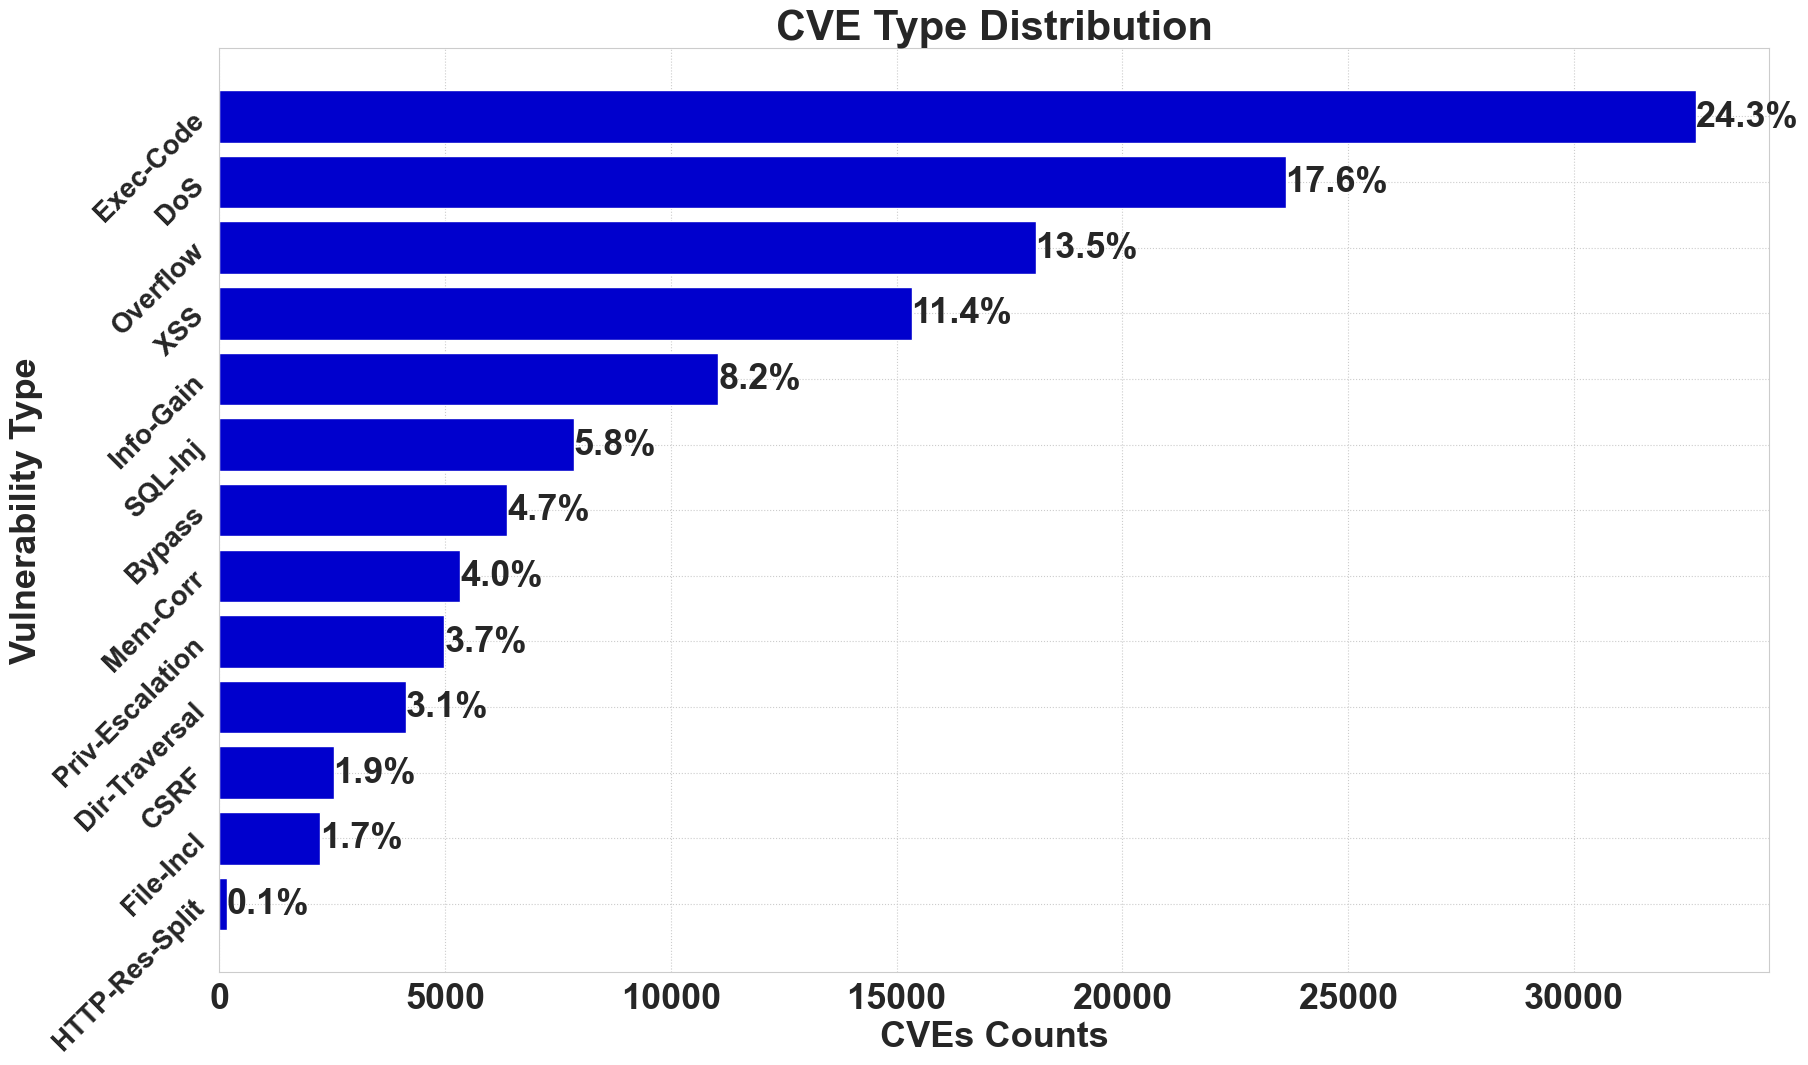

In [45]:
# Transfer the sorted grouped vul. type into list for easy plotting.
#x = ["Execute-Code", "Denial-of-Service", "Overflow", "XSS", "Gain-Information", "Sql-Injection", "Bypass-Something",
#"Memory-Corruption", "Gain-Privilege", "Directory-Traversal", "CSRF" ,"File-Inclusion", "Http-Response-Splitting"]
x = ["Exec-Code", "DoS", "Overflow", "XSS", "Info-Gain", "SQL-Inj", "Bypass", "Mem-Corr",
     "Priv-Escalation", "Dir-Traversal", "CSRF", "File-Incl", "HTTP-Res-Split"]

y = [32705, 23620, 18080, 15333, 11054, 7845,  6379, 5340, 4982, 4127,  2528,  2238,  166]

# Calculate the total count
total_count = sum(y)

#sns backgroud grid
sns.set_style("whitegrid", {'grid.linestyle': ':'})

# color
colors = ['red', 'blue', 'green', 'orange', 'purple']


# Create a vertical bar chart
f, ax = plt.subplots(figsize=(20, 12))
ax.barh(x, y, color='mediumblue')

# Add labels and title
ax.set_xlabel('CVEs Counts', fontweight='bold', fontsize=26)
ax.set_ylabel('Vulnerability Type', fontweight='bold', fontsize=26)
ax.set_title('CVE Type Distribution', fontweight='bold', fontsize=30)

# Invert the y-axis
ax.invert_yaxis()

# Rotate the y-axis labels by 0 degrees
plt.yticks(rotation=45, fontsize=20, fontweight='bold')
ax.set_xticklabels([0,5000,10000,15000,20000, 25000, 30000], fontweight='bold', fontsize=26)


# Add percentage labels to the bars
# Add percentage labels to the bars
for i in range(len(y)):
    percentage = y[i] / total_count * 100
    ax.text(y[i], i, f'{percentage:.1f}%', ha='left', va='center', fontweight='bold', fontsize=26)

# fig description

# Add the description on the figure
description = '''
Execute-Code: Exec-Code
Denial-of-Service: DoS
Overflow: Ovrflw
XSS: Cross-Site Scripting
Gain-Information: Info-Gain
Sql-Injection: SQLi
Bypass-Something: Bypass
Memory-Corruption: Mem-Corr
Gain-Privilege: Priv-Escalation
Directory-Traversal: Dir-Traversal
CSRF: Cross-Site Request Forgery
File-Inclusion: File-Incl
Http-Response-Splitting: HTTP-Splitting
'''
#plt.figtext(0.99, 0.01, description, ha='right', fontsize=8, va='bottom')

#save figure
#plt.savefig('01_CVE_Description.jpeg')

# Display the chart
plt.show()


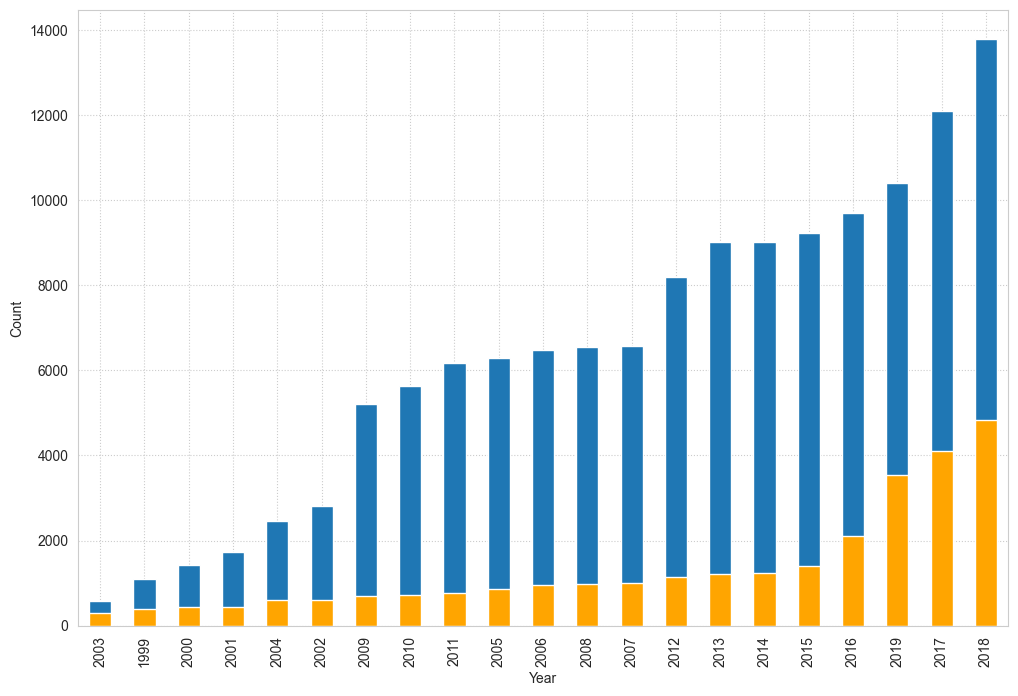

In [46]:
# visualizing available vs empty vulnerability per year

# visualizing available vs empty vulnerability per year

group1 = df_new[df_new["label_available"] == 1].groupby('CVE_Year').size().sort_values(ascending=True)
group0 =  df_new[df_new["label_available"] == 0].groupby('CVE_Year').size().sort_values(ascending=True)

# set the labels of the x-axis and y-axis
plt.figure(figsize=(12, 8))  # set the figure size to 10 inches by 6 inches

group1.plot(kind = "bar", width = 0.5)
group0.plot(kind = "bar", color = "orange", width = 0.5)
plt.xlabel('Year')
plt.ylabel('Count')

# show the plot

plt.show()


In [47]:
df_new["VulnerabilityType"].isna().sum()/len(df_new) *100

17.46024922156645

## 2. Count label by year

In [48]:
df_new.isna().sum()

CVE_ID                    0
CWE_ID                44874
NumExploits          157342
VulnerabilityType     28430
PublishDate               0
UpdateDate                0
cvss                      0
GainedAccessLevel         0
Access                    0
Complexity                0
Authentication            0
Conf.                     0
Integ.                    0
Avail.                    0
Descr.                    1
CVE_Year                  0
label_available           0
dtype: int64

In [49]:
df_new.CVE_Year.unique()

array(['2012', '2016', '2018', '2009', '2010', '2005', '2019', '2017',
       '2014', '2013', '2008', '2011', '2015', '2007', '2002', '2006',
       '2000', '2004', '2001', '2003', '1999'], dtype=object)

In [50]:
len(df_new)

162827

In [51]:
df_new.VulnerabilityType.isna().sum()

28430

## 2b Dropping rows with  missing vunerability type labels

1. We found 28,430 missing values out of 162, 827 record
2. which is approx 17% of the dataset



>  We dropped the empty rows to advoid BIAS problem in our model classification.



In [52]:
df_new2 = df_new.copy()

In [53]:
# drop rows with missing vulnerability type

df_new3 = df_new2.dropna(subset=['VulnerabilityType'])

In [54]:
len(df_new3)

134397



> Now we have 134397 records after dropping the missing values



In [55]:
df_new3['VulnerabilityType'].isna().sum() # now more empty type

0

## Distribution of my sentence length


In [56]:
desc_length = df_new3['Descr.'][1:100].str.len()
desc_length.describe()

count     99.000000
mean     269.565657
std       92.240387
min      149.000000
25%      204.000000
50%      254.000000
75%      308.500000
max      545.000000
Name: Descr., dtype: float64

# Vector Representation and TF-IDF Transformer

1. install nltk
2. Tokenization / preprocess_text
  * Stopword removal
  * puntuctions
  * Normalization / stemming
2. label encoding
3. Split data first b4 vectorization

4. BOW (bag of words)Vectorization
5. TF-IDF : term frequency-inverse document frequency



>   6. Model building




In [57]:
!pip install nltk


In [58]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string
import re

import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
#import spacy

tqdm.pandas()
#spacy_eng = spacy.load("en_core_web_sm")
lemm = WordNetLemmatizer()
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 18
nltk.download('all')


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/anthonyekle/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/anthonyekle/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/anthonyekle/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/anthonyekle/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/anthonyekle/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]

[nltk_data]    |   Package nombank.1.0 is already up-to-date!
[nltk_data]    | Downloading package nonbreaking_prefixes to
[nltk_data]    |     /Users/anthonyekle/nltk_data...
[nltk_data]    |   Package nonbreaking_prefixes is already up-to-date!
[nltk_data]    | Downloading package nps_chat to
[nltk_data]    |     /Users/anthonyekle/nltk_data...
[nltk_data]    |   Package nps_chat is already up-to-date!
[nltk_data]    | Downloading package omw to
[nltk_data]    |     /Users/anthonyekle/nltk_data...
[nltk_data]    |   Package omw is already up-to-date!
[nltk_data]    | Downloading package omw-1.4 to
[nltk_data]    |     /Users/anthonyekle/nltk_data...
[nltk_data]    |   Package omw-1.4 is already up-to-date!
[nltk_data]    | Downloading package opinion_lexicon to
[nltk_data]    |     /Users/anthonyekle/nltk_data...
[nltk_data]    |   Package opinion_lexicon is already up-to-date!
[nltk_data]    | Downloading package panlex_swadesh to
[nltk_data]    |     /Users/anthonyekle/nltk_data...

[nltk_data]    |   Package word2vec_sample is already up-to-date!
[nltk_data]    | Downloading package wordnet to
[nltk_data]    |     /Users/anthonyekle/nltk_data...
[nltk_data]    |   Package wordnet is already up-to-date!
[nltk_data]    | Downloading package wordnet2021 to
[nltk_data]    |     /Users/anthonyekle/nltk_data...
[nltk_data]    |   Package wordnet2021 is already up-to-date!
[nltk_data]    | Downloading package wordnet2022 to
[nltk_data]    |     /Users/anthonyekle/nltk_data...
[nltk_data]    |   Package wordnet2022 is already up-to-date!
[nltk_data]    | Downloading package wordnet31 to
[nltk_data]    |     /Users/anthonyekle/nltk_data...
[nltk_data]    |   Package wordnet31 is already up-to-date!
[nltk_data]    | Downloading package wordnet_ic to
[nltk_data]    |     /Users/anthonyekle/nltk_data...
[nltk_data]    |   Package wordnet_ic is already up-to-date!
[nltk_data]    | Downloading package words to
[nltk_data]    |     /Users/anthonyekle/nltk_data...
[nltk_data]   

True

### 1.  Tokenization / preprocess_text
  * Stopword removal
  * puntuctions
  * Normalization / stemming
3. Split data first b4 vectorization

In [59]:
df_new3.columns

Index(['CVE_ID', 'CWE_ID', 'NumExploits', 'VulnerabilityType', 'PublishDate',
       'UpdateDate', 'cvss', 'GainedAccessLevel', 'Access', 'Complexity',
       'Authentication', 'Conf.', 'Integ.', 'Avail.', 'Descr.', 'CVE_Year',
       'label_available'],
      dtype='object')

In [60]:
# to lower case
df_new3['Descr.'] = df_new3['Descr.'].str.lower()

# 1 remove punctuation
import re
import string
df_new3['Descr.'] = df_new3['Descr.'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))

/var/folders/6_/n5_p9hgx2mj08njw5lqlvgww0000gn/T/ipykernel_2230/3538036892.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new3['Descr.'] = df_new3['Descr.'].str.lower()
/var/folders/6_/n5_p9hgx2mj08njw5lqlvgww0000gn/T/ipykernel_2230/3538036892.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new3['Descr.'] = df_new3['Descr.'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))


In [61]:
# 2 remove stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop_words])

df_new3['Descr.'] = df_new3['Descr.'].apply(lambda x: remove_stopwords(x))


/var/folders/6_/n5_p9hgx2mj08njw5lqlvgww0000gn/T/ipykernel_2230/2753663245.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new3['Descr.'] = df_new3['Descr.'].apply(lambda x: remove_stopwords(x))


In [62]:
#3 remove urls
def remove_urls(text):
    # remove URLs
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\S+', '', text)
    text = re.sub(r'pic.twitter.com\S+', '', text)
    text = re.sub(r't\.co\S+', '', text)
    return text

df_new3['Descr.'] = df_new3['Descr.'].apply(remove_urls)


/var/folders/6_/n5_p9hgx2mj08njw5lqlvgww0000gn/T/ipykernel_2230/3446060037.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new3['Descr.'] = df_new3['Descr.'].apply(remove_urls)


In [63]:
#lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])



df_new3['Descr.'] = df_new3['Descr.'].apply(lambda x: lemmatize(x))

/var/folders/6_/n5_p9hgx2mj08njw5lqlvgww0000gn/T/ipykernel_2230/663766886.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new3['Descr.'] = df_new3['Descr.'].apply(lambda x: lemmatize(x))


### Latest dataset with feature = **Descrition** and label = VulnerabilityType

In [64]:
data = df_new3[['VulnerabilityType','Descr.']]
data.head(10)

,VulnerabilityType,Descr.
0,Execute-Code,heapbased buffer overflow flashpix plugin 4340...
1,Overflow,heapbased buffer overflow flashpix plugin 4340...
2,Denial-of-Service,heapbased buffer overflow xnview 199 allows re...
3,Execute-Code,heapbased buffer overflow xnview 199 allows re...
4,Overflow,heapbased buffer overflow xnview 199 allows re...
5,Denial-of-Service,multiple heapbased buffer overflow xnview 199 ...
6,Execute-Code,multiple heapbased buffer overflow xnview 199 ...
7,Overflow,multiple heapbased buffer overflow xnview 199 ...
8,Execute-Code,heapbased buffer overflow photoshopexe adobe p...
9,Overflow,heapbased buffer overflow photoshopexe adobe p...


### label encoding

In [65]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data['VulType_encoded'] = le.fit_transform(data['VulnerabilityType'])
#data[data["VulType_encoded"] == 8].head(1)

/var/folders/6_/n5_p9hgx2mj08njw5lqlvgww0000gn/T/ipykernel_2230/1190345976.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['VulType_encoded'] = le.fit_transform(data['VulnerabilityType'])


In [66]:
encoded = {0:'+Gain-Information', 1:'+Gain-Privilege', 2:'Bypass-Something',    3:'CSRF',  4:'Denial-of-Service',
          5:'Directory-Traversal', 6:'Execute-Code',  7:'File-Inclusion',  8:'Http-Response-Splitting', 9:'Memory-Corruption',
           10:'Overflow',11:'Sql-Injection', 12:'XSS' }

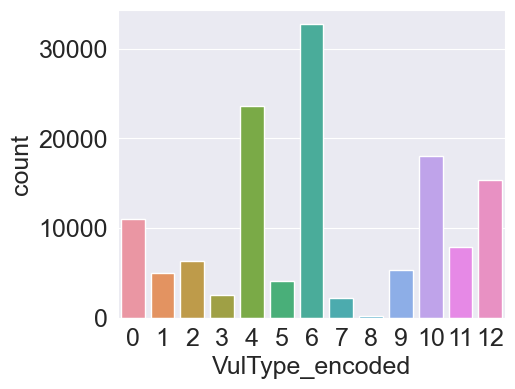

In [67]:
plt.figure(figsize=(5, 4))  # set the figure size to 10 inches by 6 inches
sns.countplot(x = data['VulType_encoded'], data= data)
# reduce the font size of the plot
ax.tick_params(axis='both', labelsize=4)

plt.show()

# Vectorization and TF-IDF

## 1. Create a vocabulary:

The next step is to create a vocabulary of all the unique words in the text data. This vocabulary will be used to represent the text data as a bag of words.

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [69]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=2500 )
X = vectorizer.fit_transform(data['Descr.'].values.tolist()).toarray()
y = data['VulType_encoded'].values

In [70]:
X.shape

(134397, 2500)

## Exporting and importing it again

In [71]:
# Export it
#import numpy as np
#np.save('X.npy', X)
#np.save('y.npy', y)


In [ ]:
# Import it now
import numpy as np
X2 = np.load('X.npy')
y2 = np.load('y.npy')
# split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)


In [72]:
# split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [73]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (107517, 2500)
X_test shape: (26880, 2500)
y_train shape: (107517,)
y_test shape: (26880,)


# Models Training

In [74]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support


In [75]:
def model_train(model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_pred_tr = model.predict(X_train)
    y_pred = model.predict(X_test)

    print("--------------------Training Performance---------------------")
    print("Accuracy: ",accuracy_score(y_train,y_pred_tr))
    print(classification_report(y_train,y_pred_tr))
    print("-------------------------------------------------------------")
    print("--------------------Testing Performance----------------------")
    print(accuracy_score(y_test,y_pred))
    print(classification_report(y_test,y_pred))
    # average: how to calculate the metrics, either "binary", "macro", "weighted", or "micro"
    precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-score:', f1_score)
    return y_pred

## 1. Naive Bayes

In [ ]:
## 1. Naive Bayes
modelNB = MultinomialNB()
y_pred1 = model_train(modelNB, X_train, X_test, y_train, y_test)


# Confusion matrix

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
#class_labels = ['Exec-Code', 'DoS attack', 'Overflow', 'XSS', 'Gain-Info', 'SQL-Inj', 'Bypass',
 #                 'Mem-Corr', 'Gain-Priv', 'Dir-Trav', 'Cross-site-RF', 'File-Incl', 'Http-Res-Spl']

# Define the class labels
class_labels = ['Info-Gain', 'Priv-Escal.', 'Bypass',
            'CSRF', 'DoS', 'Dir-Trav',
            'Exec-Code', 'File-Incl', 'HTTP-Res-Spl',
          'Mem-Corr', 'Overflow', 'SQL-Inj', 'XSS']


# Generate some random values for y_true and y_pred with shape (26880,)
n_classes = 13
y_true = y_test#np.random.randint(n_classes, size=(26880,))
y_pred = y_pred1#np.random.randint(n_classes, size=(26880,))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(18, 12))
#sns.heatmap(cm, annot=True, fmt='4g', cmap= "Blues",linewidth=.5, xticklabels=class_labels, yticklabels=class_labels, ax=ax)
sns.heatmap(cm, annot=True, fmt='4g', cmap="Blues", linewidth=.5,
            xticklabels=class_labels, yticklabels=class_labels, ax=ax,
            annot_kws={"weight": "bold"})
# Rotate the x-axis labels by 45 degrees
ax.set_xticklabels(class_labels, rotation=35, fontweight='bold')
ax.set_yticklabels(class_labels, rotation=35, fontweight='bold')


ax.set_xlabel('Predicted label', fontweight='bold', fontsize=22 )
ax.set_ylabel('True label', fontweight='bold', fontsize=22)
ax.set_title('Naive Bayes Classifier', fontweight='bold',  fontsize=32)


#fig.set_size_inches(10.5, 6.97)
fig.savefig('3a_heatmap_Naive-Bayes.png')


plt.show()


# Random Forest

In [ ]:
model = RandomForestClassifier(n_estimators=100,max_depth=15,max_features='sqrt')
y_pred2 = model_train(model, X_train, X_test, y_train, y_test)

## Confusion matrix

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Exec-Code', 'DoS attack', 'Overflow', 'XSS', 'Gain-Info', 'SQL-Inj', 'Bypass',
                  'Mem-Corr', 'Gain-Privilege', 'Dir-Traversal', 'Cross-site-RF', 'File-Incl', 'HTTP-Res-Split']

# Define the class labels
#class_labels = ['Gain-Info', 'Gain-Priv', 'Bypass',
 #               'CSRF', 'DoS', 'Dir-Trav',
  #              'Exec-Code', 'File-Inclu', 'Http-Res-Spl',
   #             'Mem-Corr', 'Overflow', 'Sql', 'XSS']

# Generate some random values for y_true and y_pred with shape (26880,)
n_classes = 13
y_true = y_test#np.random.randint(n_classes, size=(26880,))
y_pred = y_pred2#np.random.randint(n_classes, size=(26880,))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='4g', cmap= "Blues",linewidth=.5, xticklabels=class_labels, yticklabels=class_labels, ax=ax)

# Rotate the x-axis labels by 45 degrees
ax.set_xticklabels(class_labels, rotation=45)

ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Random Forest')


#fig.set_size_inches(10.5, 6.97)
#fig.savefig('4_Random-Forest.png', dpi=300, bbox_inches='tight')


plt.show()


# Decision Tree

In [ ]:
model = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)
y_pred3 = model_train(model, X_train, X_test, y_train, y_test)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
class_labels = ['Gain-Info', 'Gain-Priv', 'Bypass',
                'CSRF', 'DoS', 'Dir-Trav',
                'Exec-Code', 'File-Inclu', 'Http-Res-Spl',
                'Mem-Corr', 'Overflow', 'Sql', 'XSS']

# Generate some random values for y_true and y_pred with shape (26880,)
n_classes = 13
y_true = y_test#np.random.randint(n_classes, size=(26880,))
y_pred = y_pred3#np.random.randint(n_classes, size=(26880,))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='4g', cmap= "Blues",linewidth=.5, xticklabels=class_labels, yticklabels=class_labels, ax=ax)

# Rotate the x-axis labels by 45 degrees
ax.set_xticklabels(class_labels, rotation=45)

ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Decision Tree')


#fig.set_size_inches(10.5, 6.97)
#fig.savefig('5_Decision-Tree.png', dpi=300, bbox_inches='tight')


plt.show()


# Light gbm

In [ ]:
from lightgbm import LGBMClassifier
model = LGBMClassifier()
y_pred4 = model_train(model, X_train, X_test, y_train, y_test)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
#class_labels = ['Exec-Code', 'DoS attack', 'Overflow', 'XSS', 'Gain-Info', 'SQL-Inj', 'Bypass',
 #                 'Mem-Corr', 'Gain-Priv', 'Dir-Trav', 'Cross-site-RF', 'File-Incl', 'Http-Res-Spl']

# Define the class labels
class_labels = ['Info-Gain', 'Priv-Escal.', 'Bypass',
            'CSRF', 'DoS', 'Dir-Trav',
            'Exec-Code', 'File-Incl', 'HTTP-Res-Spl',
          'Mem-Corr', 'Overflow', 'SQL-Inj', 'XSS']


# Generate some random values for y_true and y_pred with shape (26880,)
n_classes = 13
y_true = y_test#np.random.randint(n_classes, size=(26880,))
y_pred = y_pred4#np.random.randint(n_classes, size=(26880,))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(16, 11))
#sns.heatmap(cm, annot=True, fmt='4g', cmap= "Blues",linewidth=.5, xticklabels=class_labels, yticklabels=class_labels, ax=ax)
sns.heatmap(cm, annot=True, fmt='4g', cmap="Blues", linewidth=.5,
            xticklabels=class_labels, yticklabels=class_labels, ax=ax,
            annot_kws={"weight": "bold"})
# Rotate the x-axis labels by 45 degrees
ax.set_xticklabels(class_labels, rotation=35, fontweight='bold')
ax.set_yticklabels(class_labels, rotation=35, fontweight='bold')


ax.set_xlabel('Predicted label', fontweight='bold', fontsize=22 )
ax.set_ylabel('True label', fontweight='bold', fontsize=22)
ax.set_title('LightGBM Classifier', fontweight='bold',  fontsize=32)



#fig.set_size_inches(10.5, 6.97)
fig.savefig('04_LightGBM.png', dpi=300, bbox_inches='tight')


plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
class_labels = ['Gain-Info', 'Gain-Priv', 'Bypass',
                'CSRF', 'DoS', 'Dir-Trav',
                'Exec-Code', 'File-Inclu', 'Http-Res-Spl',
                'Mem-Corr', 'Overflow', 'Sql', 'XSS']

# Generate some random values for y_true and y_pred with shape (26880,)
n_classes = 13
y_true = y_test#np.random.randint(n_classes, size=(26880,))
y_pred = y_pred4#np.random.randint(n_classes, size=(26880,))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='4g', cmap= "Blues",linewidth=.5, xticklabels=class_labels, yticklabels=class_labels, ax=ax)

# Rotate the x-axis labels by 45 degrees
ax.set_xticklabels(class_labels, rotation=45)

ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('MultinomialNB')


#fig.set_size_inches(10.5, 6.97)
fig.savefig('6_LightGBM.png', dpi=300, bbox_inches='tight')


plt.show()


# SVM

In [ ]:
from sklearn import svm
svm_model = svm.SVC(kernel='linear', decision_function_shape='ovr')
y_pred4 = model_train(svm_model, X_train, X_test, y_train, y_test)

## Confusion matrix

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
class_labels = ['Gain-Info', 'Gain-Priv', 'Bypass',
                'CSRF', 'DoS', 'Dir-Trav',
                'Exec-Code', 'File-Inclu', 'Http-Res-Spl',
                'Mem-Corr', 'Overflow', 'Sql', 'XSS']

# Generate some random values for y_true and y_pred with shape (26880,)
n_classes = 13
y_true = y_test#np.random.randint(n_classes, size=(26880,))
y_pred = y_pred4#np.random.randint(n_classes, size=(26880,))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='4g', cmap= "Blues",linewidth=.5, xticklabels=class_labels, yticklabels=class_labels, ax=ax)

# Rotate the x-axis labels by 45 degrees
ax.set_xticklabels(class_labels, rotation=45)

ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('SVM')


#fig.set_size_inches(10.5, 6.97)
fig.savefig('6b_SVM.png', dpi=300, bbox_inches='tight')


plt.show()


# SMOTE to Balance Data

## PCA transformation to balance the data, Principal Component Analysis
## SMOTE Technique (Over-Sampling):
 * SMOTE stands for Synthetic Minority Over-sampling Technique. Unlike Random UnderSampling, SMOTE creates new synthetic points in order to have an equal balance of the classes. This is another alternative for solving the "class imbalance problems".

* Understanding SMOTE:
Solving the Class Imbalance:
SMOTE creates synthetic points from the minority class in order to reach an equal balance between the minority and majority class.

* Location of the synthetic points:
SMOTE picks the distance between the closest neighbors of the minority class, in between these distances it creates synthetic points.

* Final Effect:
More information is retained since we didn't have to delete any rows unlike in random undersampling.

Accuracy || Time Tradeoff:
Although it is likely that SMOTE will be more accurate than random under-sampling, it will take more time to train since no rows are eliminated as previously stated.

In [76]:
# Import it now
import numpy as np
#X2 = np.load('X.npy')
#y2 = np.load('y.npy')
# split the data into training and testing sets
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X2,y2,test_size=0.2,random_state=42)



# Apply SMOTE on the training set
from imblearn.over_sampling import SMOTE

# test data
smote = SMOTE(random_state=42)
X_test_resampled, y_test_resampled = smote.fit_resample(X_test, y_test)


# train data
# Smote on Train data set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# before
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '12': {} \n".format(sum(y_train==12)))


print('After OverSampling, the shape of train_X: {}'.format(X_train_resampled.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_resampled.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_resampled==1)))
print("After OverSampling, counts of label '12': {}".format(sum(y_train_resampled==12)))

Before OverSampling, counts of label '1': 3974
Before OverSampling, counts of label '12': 12259 

After OverSampling, the shape of train_X: (341224, 2500)
After OverSampling, the shape of train_y: (341224,) 

After OverSampling, counts of label '1': 26248
After OverSampling, counts of label '12': 26248


In [77]:
# Save the sampled data and train somewhere else.
#y_pred1b = model_train(modelNB, X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)

#np.save('X_train_resampled.npy', X_train_resampled)
#np.save("X_test_resampled", X_test_resampled)
#np.save("y_train_resampled", y_train_resampled)
#np.save("y_test_resampled", y_test_resampled)

In [78]:
type(X_train_resampled)

numpy.ndarray

In [79]:
# Count the number of instances for each class
print("===========BEFORE SMOTE==============")
class_counts = np.bincount(y_test)

# Print the class counts
for i, count in enumerate(class_counts):
    print("Class {}: {}".format(i, count))

# Print the sum of all classes
print("Total instances: {}".format(np.sum(class_counts)))


print("===========BEFORE SMOTE==============")
# Count the number of instances for each class
class_counts = np.bincount(y_test_resampled)

# Print the class counts
for i, count in enumerate(class_counts):
    print("Class {}: {}".format(i, count))

# Print the sum of all classes
print("Total instances: {}".format(np.sum(class_counts)))

===========BEFORE SMOTE==============
Class 0: 2307
Class 1: 1008
Class 2: 1237
Class 3: 535
Class 4: 4818
Class 5: 829
Class 6: 6457
Class 7: 412
Class 8: 30
Class 9: 1042
Class 10: 3637
Class 11: 1494
Class 12: 3074
Total instances: 26880
===========BEFORE SMOTE==============
Class 0: 6457
Class 1: 6457
Class 2: 6457
Class 3: 6457
Class 4: 6457
Class 5: 6457
Class 6: 6457
Class 7: 6457
Class 8: 6457
Class 9: 6457
Class 10: 6457
Class 11: 6457
Class 12: 6457
Total instances: 83941


In [80]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


In [81]:
# standardize the data
#x_train2 = scaler.fit_transform(X_train_resampled)
#x_test2 = scaler.transform(X_test_resampled)
#test_final2=scaler.transform(test_final)
# convert to 1-D

#y_train2 = np.array(y_train_resampled).reshape((-1, ))
#y_test2 = np.array(y_test_resampled).reshape((-1, ))

# Models with SMOTE data


## 1. Naive Bayes

In [82]:

modelNB = MultinomialNB()
y_pred1b = model_train(modelNB, X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)


--------------------Training Performance---------------------
Accuracy:  0.8078036714885237
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     26248
           1       0.84      0.91      0.87     26248
           2       0.76      0.89      0.82     26248
           3       0.92      0.96      0.94     26248
           4       0.65      0.67      0.66     26248
           5       0.93      0.96      0.95     26248
           6       0.60      0.23      0.33     26248
           7       0.93      0.97      0.95     26248
           8       0.99      0.99      0.99     26248
           9       0.59      0.81      0.68     26248
          10       0.56      0.50      0.53     26248
          11       0.80      0.95      0.87     26248
          12       0.95      0.85      0.90     26248

    accuracy                           0.81    341224
   macro avg       0.80      0.81      0.80    341224
weighted avg       0.80      0.81      0.8

# Confusion matrix

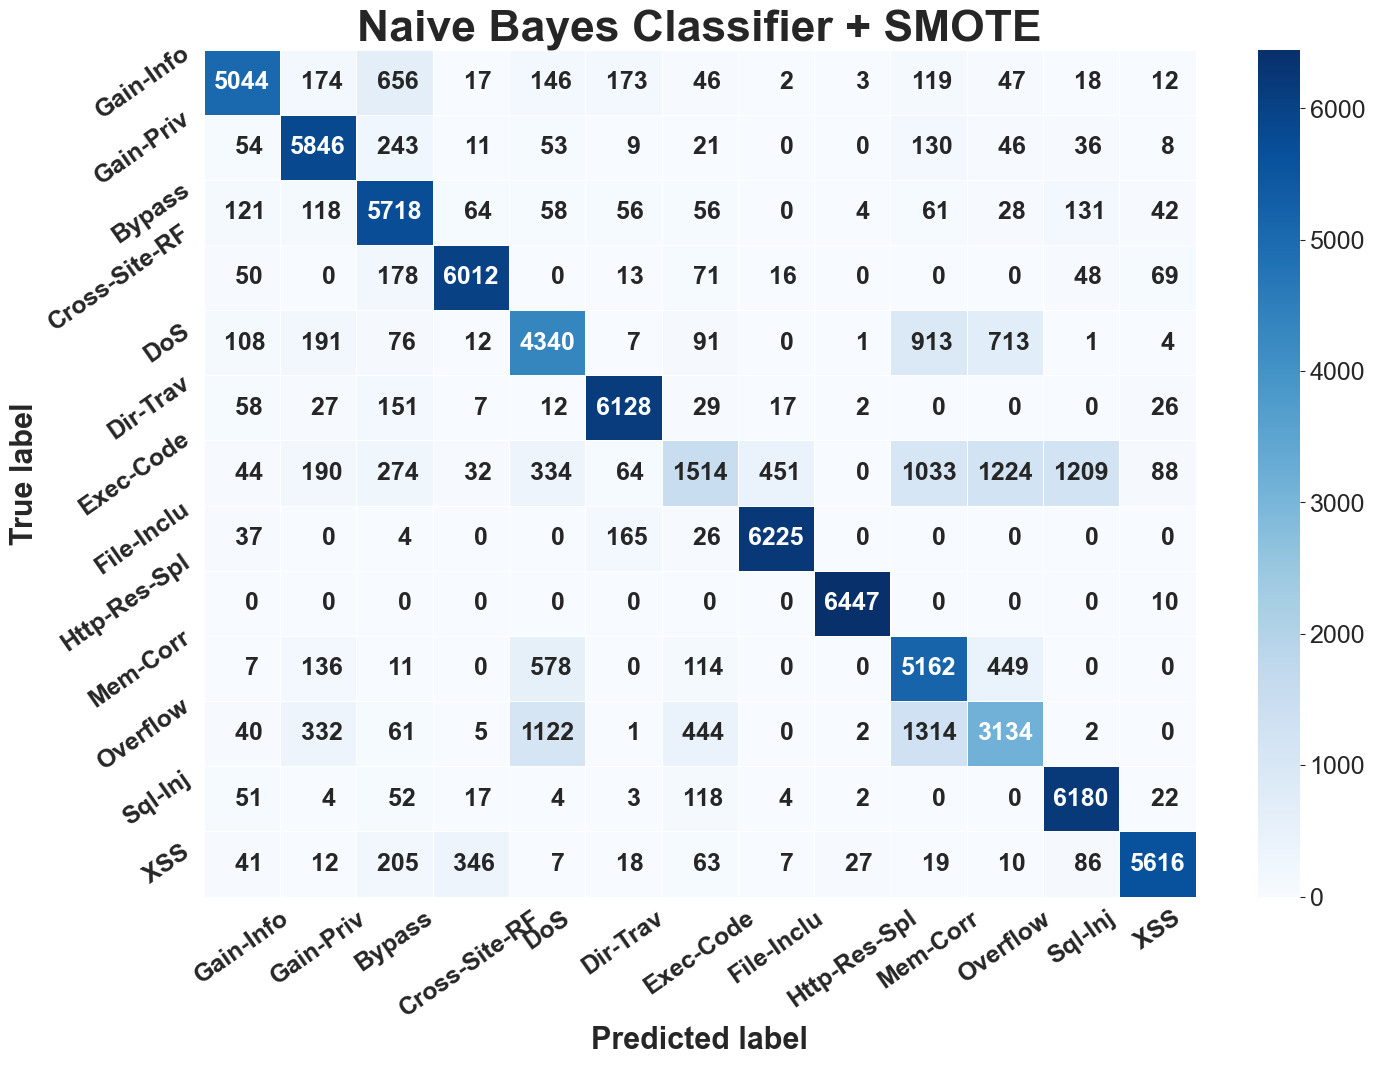

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
class_labels = ['Gain-Info', 'Gain-Priv', 'Bypass',
            'Cross-Site-RF', 'DoS', 'Dir-Trav',
            'Exec-Code', 'File-Inclu', 'Http-Res-Spl',
          'Mem-Corr', 'Overflow', 'Sql-Inj', 'XSS']

# Generate some random values for y_true and y_pred with shape (26880,)
n_classes = 13
y_true = y_test_resampled #np.random.randint(n_classes, size=(26880,))
y_pred = y_pred1b#np.random.randint(n_classes, size=(26880,))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(16, 11))
sns.heatmap(cm, annot=True, fmt='4g', cmap="Blues", linewidth=.5,
            xticklabels=class_labels, yticklabels=class_labels, ax=ax,
            annot_kws={"weight": "bold"})

# Rotate the x-axis labels by 45 degrees
ax.set_xticklabels(class_labels, rotation=35, fontweight='bold')
ax.set_yticklabels(class_labels, rotation=35, fontweight='bold')

ax.set_xlabel('Predicted label', fontweight='bold', fontsize=22)
ax.set_ylabel('True label', fontweight='bold', fontsize=22)

ax.set_title('Naive Bayes Classifier + SMOTE', fontweight='bold' , fontsize=32)
#fig.set_size_inches(10.5, 6.97)
fig.savefig('7a_Naive-Bayes-SMOTE2.png', dpi=300, bbox_inches='tight')



plt.show()


In [ ]:
X_test_resampled.shape

# 2 Random Forest

In [ ]:
modelRF = RandomForestClassifier(n_estimators=100,max_depth=15,max_features='sqrt')
y_pred2b = model_train(modelRF, X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)


# Confusion matrix

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
class_labels = ['Gain-Info', 'Gain-Priv', 'Bypass',
                'CSRF', 'DoS', 'Dir-Trav',
                'Exec-Code', 'File-Inclu', 'Http-Res-Spl',
                'Mem-Corr', 'Overflow', 'Sql', 'XSS']

# Generate some random values for y_true and y_pred with shape (26880,)
n_classes = 13
y_true = y_test_resampled[0:40000]#np.random.randint(n_classes, size=(26880,))
y_pred = y_pred2b#np.random.randint(n_classes, size=(26880,))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='4g', cmap= "Blues",linewidth=.5, xticklabels=class_labels, yticklabels=class_labels, ax=ax)

# Rotate the x-axis labels by 45 degrees
ax.set_xticklabels(class_labels, rotation=45)


ax.set_xlabel('Predicted label', fontsize=14)
ax.set_ylabel('True label', fontsize=14)
ax.set_title('Random Forest with SMOTE', fontsize=16)
#fig.set_size_inches(10.5, 6.97)
fig.savefig('9_Random-Forest-SMOTE.png', dpi=300, bbox_inches='tight')



plt.show()


# 3. Decision tree

In [ ]:
modelDT = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)
y_pred3b = model_train(modelDT, X_train_resampled[0:250000], X_test_resampled[0:40000], y_train_resampled[0:250000], y_test_resampled[0:40000])


# Confusion Matrix

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
class_labels = ['Gain-Info', 'Gain-Priv', 'Bypass',
                'CSRF', 'DoS', 'Dir-Trav',
                'Exec-Code', 'File-Inclu', 'Http-Res-Spl',
                'Mem-Corr', 'Overflow', 'Sql', 'XSS']

# Generate some random values for y_true and y_pred with shape (26880,)
n_classes = 13
y_true = y_test_resampled[0:40000]#np.random.randint(n_classes, size=(26880,))
y_pred = y_pred3b#np.random.randint(n_classes, size=(26880,))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='4g', cmap= "Blues",linewidth=.5, xticklabels=class_labels, yticklabels=class_labels, ax=ax)

# Rotate the x-axis labels by 45 degrees
ax.set_xticklabels(class_labels, rotation=45)


ax.set_xlabel('Predicted label', fontsize=14)
ax.set_ylabel('True label', fontsize=14)
ax.set_title('Decision Tree with SMOTE', fontsize=16)
#fig.set_size_inches(10.5, 6.97)
fig.savefig('8_Decision-Tree-SMOTE.png', dpi=300, bbox_inches='tight')



plt.show()


# LightGBM


In [85]:
from lightgbm import LGBMClassifier
model_LGBM = LGBMClassifier()
y_pred5b = model_train(model_LGBM, X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled)


--------------------Training Performance---------------------
Accuracy:  0.8907257402761822
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     26248
           1       0.94      0.99      0.96     26248
           2       0.95      0.98      0.96     26248
           3       0.98      1.00      0.99     26248
           4       0.87      0.69      0.77     26248
           5       0.99      0.99      0.99     26248
           6       0.89      0.35      0.50     26248
           7       0.94      1.00      0.97     26248
           8       1.00      1.00      1.00     26248
           9       0.67      0.99      0.80     26248
          10       0.67      0.67      0.67     26248
          11       0.84      0.99      0.91     26248
          12       0.98      0.97      0.98     26248

    accuracy                           0.89    341224
   macro avg       0.90      0.89      0.88    341224
weighted avg       0.90      0.89      0.8

## confussion matrix

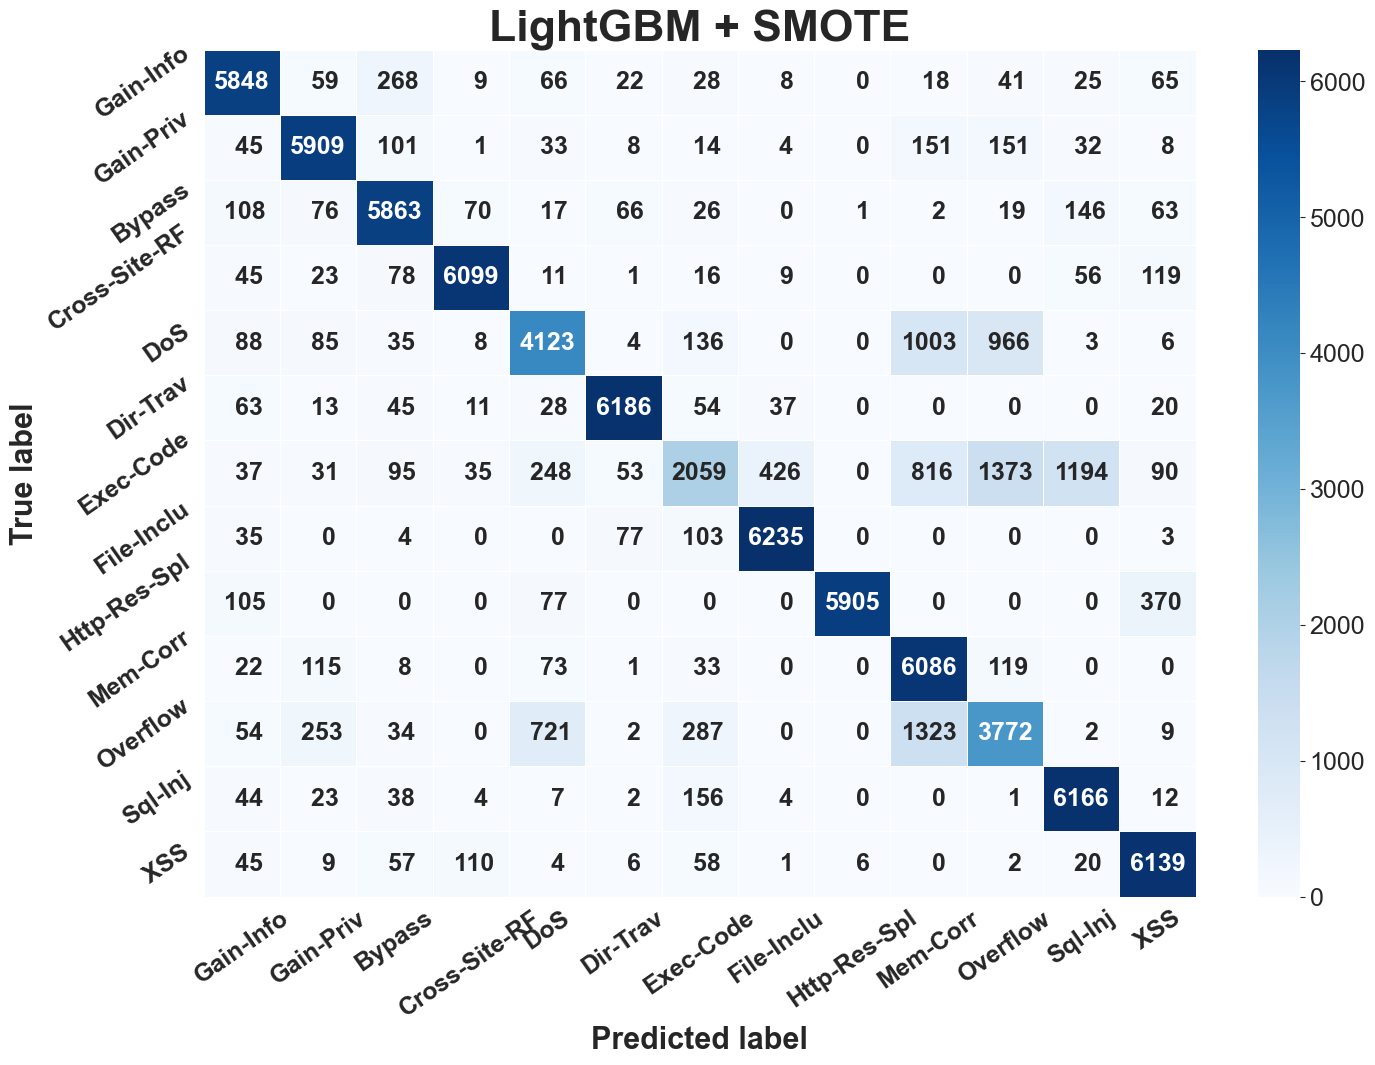

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the class labels
class_labels = ['Gain-Info', 'Gain-Priv', 'Bypass',
            'Cross-Site-RF', 'DoS', 'Dir-Trav',
            'Exec-Code', 'File-Inclu', 'Http-Res-Spl',
          'Mem-Corr', 'Overflow', 'Sql-Inj', 'XSS']


# Generate some random values for y_true and y_pred with shape (26880,)
n_classes = 13
y_true = y_test_resampled#np.random.randint(n_classes, size=(26880,))
y_pred = y_pred5b#np.random.randint(n_classes, size=(26880,))


# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(16, 11))
sns.heatmap(cm, annot=True, fmt='4g', cmap="Blues", linewidth=.5,
            xticklabels=class_labels, yticklabels=class_labels, ax=ax,
            annot_kws={"weight": "bold"})

# Rotate the x-axis labels by 45 degrees
ax.set_xticklabels(class_labels, rotation=35, fontweight='bold')
ax.set_yticklabels(class_labels, rotation=35, fontweight='bold')

ax.set_xlabel('Predicted label', fontweight='bold', fontsize=22)
ax.set_ylabel('True label', fontweight='bold', fontsize=22)

ax.set_title('LightGBM + SMOTE', fontweight='bold' , fontsize=32)

#fig.set_size_inches(10.5, 6.97)
fig.savefig('9_LightGBM-SMOTE.png', dpi=300, bbox_inches='tight')



plt.show()


